<h1 style="text-align: center;">Tennis Analyzer ML Model V2</h1>
<h3 style="text-align: center;">Dan Warnick</h3>

<p>To start we will begin by selecting the data points we want to analyze with existing known results. For each data entry we will have two players each with the following data entries.</p>
<table style="font-size: .8em;">
    <tr>
        <th>Player Name</th>
    </tr>
</table>
<p>Along with match facts like Clay/Hard/Grass Court or Indoor/Outdoor. In the future may want to add weather and adjust certain parameters for more accuracy and more data points to train from, however for now this seems a good start.</p>

<h2>1.) Collect Data Efficiently</h2>

In [535]:
import django
from django.http import HttpResponse
from django.template import loader
import os
from django.db import models
import torch
from math import ceil, floor
import math
import numpy as np
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from asgiref.sync import sync_to_async # type: ignore
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib

# os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'breakpoint.settings')
# django.setup()

# from render.models import *

In [536]:
start = '20130101'
end = '20231231'
match_type = 'm'

In [537]:
start_date = datetime.strptime(start, '%Y%m%d').date()
end_date = datetime.strptime(end, '%Y%m%d').date()

# if match_type == 'm':   
#     typer = MensTennisMatch
#     insert_db = MensTennisMatchStats
# else:
#     typer = WomensTennisMatch
#     insert_db = WomensTennisMatchStats

# query = insert_db.objects.filter(
#         tourney_date__range=(start_date, end_date)
#     ).order_by('tourney_date')
    
# games = await sync_to_async(list)(query.all().values())

df = pd.read_csv('testfree10.csv')
df['tourney_date'] = pd.to_datetime(df['tourney_date']).dt.date
df = df[(df['tourney_date'] >= start_date) & (df['tourney_date'] <= end_date)]

df = df.drop(['tourney_id', 'tourney_name', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug'], axis=1)

# df = pd.DataFrame(games).drop(['tourney_id', 'tourney_name', 'tourney_date', 'a_player_name', 'b_player_name', 'a_player_id', 'a_player_slug', 'b_player_id', 'b_player_slug','a_win_percent', 'a_serve_rating', 'a_return_rating', 'a_pressure_rating', 'a_avg_vs_elo', 'a_matches_played', 'b_win_percent', 'b_serve_rating', 'b_return_rating', 'b_pressure_rating', 'b_avg_vs_elo', 'b_matches_played', 'a_odds', 'b_odds'], axis=1)

one_hot_encoder = OneHotEncoder(sparse_output=False)

# One-Hot Encode the 'category_text' column
category_encoded = one_hot_encoder.fit_transform(df[['surface']])

# Convert to DataFrame
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder.get_feature_names_out(['surface']))

# Concatenate the one-hot encoded columns back to the original DataFrame
df = pd.concat([df, category_encoded_df], axis=1)

# Drop the original 'category_text' column
df.drop('surface', axis=1, inplace=True)
print(len(df))

36813


In [538]:
df.head()

,best_of,match_num,a_player_rank,b_player_rank,a_recent_elo_rating,a_recent_point_elo_rating,a_recent_game_elo_rating,a_recent_set_elo_rating,a_recent_service_game_elo_rating,a_recent_return_game_elo_rating,...,b_latest_surface_service_game_elo_rating,b_latest_surface_return_game_elo_rating,b_latest_surface_tie_break_elo_rating,a_b_win,a_odds,b_odds,surface_Carpet,surface_Clay,surface_Grass,surface_Hard
8138,3.0,11.0,63.0,73.0,0.583734,0.502238,0.523361,0.617438,0.543951,0.311099,...,0.500618,0.329557,0.254230,1.0,1.91,1.83,0.0,0.0,0.0,1.0
8139,3.0,10.0,62.0,30.0,0.475564,0.500315,0.502556,0.477358,0.513402,0.618030,...,0.505037,0.612666,0.602808,1.0,2.18,1.65,0.0,0.0,0.0,1.0
8140,3.0,4.0,70.0,54.0,0.563793,0.533238,0.550533,0.586957,0.758503,0.281005,...,0.752993,0.295605,0.765523,1.0,1.52,2.47,0.0,0.0,0.0,1.0
8141,3.0,8.0,104.0,376.0,0.674109,0.549104,0.599120,0.663299,0.460431,0.404943,...,0.443347,0.408324,0.170376,1.0,NaN,NaN,0.0,1.0,0.0,0.0
8142,3.0,7.0,59.0,26.0,0.332438,0.426866,0.391092,0.332182,0.472162,0.181052,...,0.459465,0.189015,0.366187,1.0,2.22,1.63,0.0,1.0,0.0,0.0


In [539]:
# Create a scatter plot
# df = df[~(df == 1500).any(axis=1)]
# plt.figure(figsize=(5, 5))

# # Plot a_elo_rating vs b_elo_rating for a_b_win == 1
# x1 = df[df['a_b_win'] == 1]['a_recent_elo_rating']
# y1 = df[df['a_b_win'] == 1]['b_recent_elo_rating']
# plt.scatter(x1, y1, color='blue', label='Favorite Wins', s=.5, alpha=0.5)

# # Plot b_elo_rating vs a_elo_rating for a_b_win == 0
# x2 = df[df['a_b_win'] == 0]['b_recent_elo_rating']
# y2 = df[df['a_b_win'] == 0]['a_recent_elo_rating']
# plt.scatter(x2, y2, color='orange', label='Upset', s=.5, alpha=0.5)

# # Combine data for a single trendline
# combined_x = np.concatenate([x1, x2])
# combined_y = np.concatenate([y1, y2])

# # Fit a polynomial of degree 2 to the combined data
# print(combined_x)
# coefficients = np.polyfit(combined_x, combined_y, 3)
# polynomial = np.poly1d(coefficients)
# trendline_x = np.linspace(combined_x.min(), combined_x.max(), 100)
# trendline_y = polynomial(trendline_x)
# plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Quadratic Trendline')

# # Setting the limits for x and y axis
# plt.xlim(1100, 2300)
# plt.ylim(1100, 2300)

# # Adding labels and title
# plt.xlabel('ELO Rating Winner')
# plt.ylabel('ELO Rating Loser')
# plt.title('Scatter Plot of ELO Ratings based on Win/Loss')
# plt.grid(True)
# plt.legend()

# # Show the plot
# plt.show()

/Users/danw/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3505: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


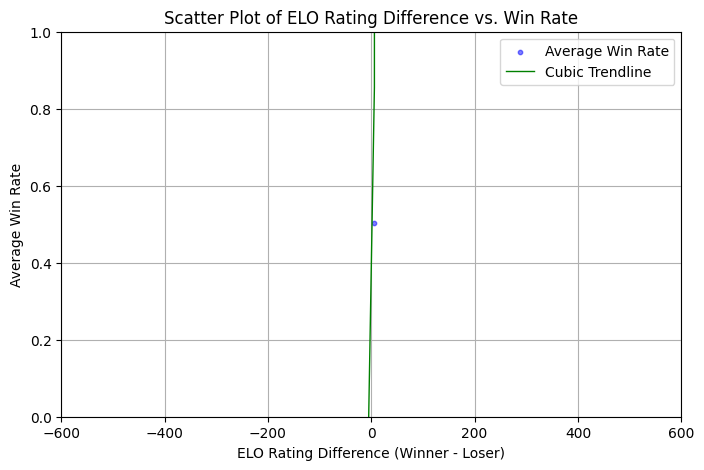

In [540]:
plt.figure(figsize=(8, 5))

df['elo_diff'] = df['a_recent_elo_rating']

# Create bins for ELO difference in intervals of 10
bins = np.arange(df['elo_diff'].min(), df['elo_diff'].max() + 10, 10)
labels = (bins[:-1] + bins[1:]) / 2
df['elo_diff_bin'] = pd.cut(df['elo_diff'], bins=bins, labels=labels, include_lowest=True)

# Calculate average win rate at each ELO difference bin
average_win_rate = df.groupby('elo_diff_bin')['a_b_win'].mean().reset_index()
average_win_rate.columns = ['elo_diff_bin', 'avg_win_rate']

# Convert the bin labels to numeric values
average_win_rate['elo_diff_bin'] = average_win_rate['elo_diff_bin'].astype(float)

average_win_rate = average_win_rate[~np.isnan(average_win_rate).any(axis=1)]

# Create the scatter plot
plt.scatter(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], color='blue', label='Average Win Rate', s=10, alpha=0.5)

# Fit a polynomial of degree 3 to the average win rate data
coefficients = np.polyfit(average_win_rate['elo_diff_bin'], average_win_rate['avg_win_rate'], 5)
polynomial = np.poly1d(coefficients)
trendline_x = np.linspace(-600, 600, 100)
trendline_y = polynomial(trendline_x)
plt.plot(trendline_x, trendline_y, color='green', linewidth=1, label='Cubic Trendline')

# Setting the limits for x and y axis
plt.xlim(-600, 600)
plt.ylim(0, 1)

# Adding labels and title
plt.xlabel('ELO Rating Difference (Winner - Loser)')
plt.ylabel('Average Win Rate')
plt.title('Scatter Plot of ELO Rating Difference vs. Win Rate')
plt.grid(True)
plt.legend()

# Show the plot
plt.show()

In [541]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [542]:
class OutcomeProbability(nn.Module):
    def __init__(self, input_dim=36, dropout_prob=0.33):
        hidden_dim = int(input_dim * (2/3))
        super(OutcomeProbability, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)  # No sigmoid activation here
        return x

In [543]:

df = df.dropna()
df = df[~(df == .5).any(axis=1)]

# Extract odds and keep track of original indices
odds_df = df[['a_odds', 'b_odds']].copy()
odds_df['index'] = df.index

# Drop odds columns from the main DataFrame
df = df.drop(columns=['a_odds', 'b_odds'])

# Separate features and target variable
y = df['a_b_win'].values
X = df.drop('a_b_win', axis=1).values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, odds_df['index'].values, test_size=1/5, random_state=42
)

# Scale the features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
train_dataset = data.TensorDataset(
    torch.tensor(X_train, dtype=torch.float32), 
    torch.tensor(y_train, dtype=torch.float32)
)
test_dataset = data.TensorDataset(
    torch.tensor(X_test, dtype=torch.float32), 
    torch.tensor(y_test, dtype=torch.float32)
)

# Create DataLoader objects
batch_size = 32
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = OutcomeProbability(input_dim=X.shape[1])
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = ceil(len(X_train) / batch_size)
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 25 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Testing loop
model.eval()
predictions = []
actuals = []
with torch.no_grad():
    test_loss = 0
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        predictions.extend(torch.sigmoid(outputs).numpy())
        actuals.extend(labels.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Accuracy: {accuracy:.2f}%')

# Convert predictions and actuals to numpy arrays
predictions = np.array(predictions)
actuals = np.array(actuals)

# Create a DataFrame with actuals and predictions
comparison_df = pd.DataFrame({
    'Actual': actuals,
    'Predicted': predictions
})
comparison_df['index'] = idx_test

# Merge the predictions with the original odds DataFrame
comparison_test_values = odds_df.set_index('index').loc[idx_test]
comparison_df = comparison_df.merge(
    comparison_test_values.reset_index(),
    on='index',
    suffixes=('_model', '_original')
)

Epoch [25/404], Loss: 0.8178
Epoch [50/404], Loss: 0.6732
Epoch [75/404], Loss: 0.5579
Epoch [100/404], Loss: 0.7131
Epoch [125/404], Loss: 0.6201
Epoch [150/404], Loss: 0.3882
Epoch [175/404], Loss: 0.6189
Epoch [200/404], Loss: 0.5283
Epoch [225/404], Loss: 0.5279
Epoch [250/404], Loss: 0.7547
Epoch [275/404], Loss: 0.6228
Epoch [300/404], Loss: 0.5235
Epoch [325/404], Loss: 0.6638
Epoch [350/404], Loss: 0.5346
Epoch [375/404], Loss: 0.4926
Epoch [400/404], Loss: 0.6698
Test Loss: 0.5980, Accuracy: 67.52%


In [544]:
print(comparison_df.head())

   Actual  Predicted  index  a_odds  b_odds
0     0.0   0.393506  16799    2.49    1.52
1     1.0   0.755807  10983    1.19    4.50
2     1.0   0.572211   8991    1.38    2.93
3     0.0   0.554271  28530    1.59    2.37
4     1.0   0.325378   8929    2.46    1.53


In [548]:
better = 0
total_won = 0
diff_fav = 0
bet_correct = 0

model_correct = 0
vegas_correct = 0
vegas_total = 0

wrong = 0
comparison_df = comparison_df.dropna()
length = len(comparison_df)

confidence_pct = .8

for i, row in comparison_df.iterrows():

    if row['Predicted'] > confidence_pct and row['Predicted'] > 1/row['a_odds']+.15:
        better += 1
        if(row['Actual'] == 1):
            bet_correct += 1
            total_won += row['a_odds']-1
        else:
            wrong += 1
            total_won -= 1

    if row['Predicted'] < 1-confidence_pct and 1-row['Predicted'] > 1/row['b_odds']+.15:
        better += 1
        if(row['Actual'] == 0):
            bet_correct += 1
            total_won += row['b_odds']-1
        else:
            wrong += 1
            total_won -= 1

    if round(row['Predicted']) != round(1/row['a_odds']):
        diff_fav += 1

    if row['Actual']==1 and row['a_odds'] < row['b_odds']:
        # print(f"A odds : {row['a_odds']} B odds : {row['b_odds']}")
        vegas_correct += 1

    if row['Actual']==0 and row['a_odds'] > row['b_odds']:
        vegas_correct += 1

    if round(row['Predicted']) == round(row['Actual']):
        model_correct += 1


print(f"Total won on $1 bets: {total_won:.2f} on a total # bets: {better} from a total of {length} games")
print(f"Amount of differing favorites {diff_fav/length}")
print(f"Amount of incorrect bets : {wrong/better}")
print(f"Correct Bets: {bet_correct/better}")
print(f"Model % Correct : {model_correct/length} Vegas Correct % : {vegas_correct/length}")


Total won on $1 bets: 0.32 on a total # bets: 10 from a total of 3230 games
Amount of differing favorites 0.13188854489164087
Amount of incorrect bets : 0.3
Correct Bets: 0.7
Model % Correct : 0.6752321981424149 Vegas Correct % : 0.6885448916408669
